# Blind Dating Analysis

File to process and analyze the data from the Blind Dating event.

The main goal is to determine which questions where useful in predicting a good date
based on a number of different outcomes.

Although "dating" might be the ideal outcome, seeing if people found compatability or
a new friend through the process should also be considered a success as the questions
largely asked about personality compatability.

Any findings should be considered in determining which questions to change, add, and remove.

In [272]:
# Importing neccesary packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score


In [209]:
# Importing the datasets

dfPre = pd.read_csv("response.csv", header=None)
dfPost = pd.read_csv("postResponse.csv", header=None)
dfPreference = pd.read_csv("PreferenceList.csv", header=None)

Due to poor planning in the early part of this project, an unideal approach needed to be made regarding receiving questions in the code. Direct indexing is used. The reason the response.csv file has so many blank spaces that aren't just cleared is because it would mess up the indexing process. After this step, everything else follows more naturally.

This block with "qNames" lists all the info regarding what each question is in a shortened form to be referenced in visuals.

# Question Data and Indexing

Lists all of the question in two dictionaries:
qNames: each question label and what it represents
qData: each question label and what indices it calls, and a polarity number

In [258]:
# Creating dictionaries to map question numbers to their names
# Responses are formatted as Self vs. Want
# Negative signs (i.e. -58) do not mean a negative index, but rather a polarity flip
qNames = {
    # Emotion
    "Q1": "Cries often VS. Uncofmortable consoling the unwell", # Indices 59 VS. -58
    "Q2": "Tend to be anxious VS. Values self esteem in someone", # Indices 62 VS. -64
    "Q3": "Clearly articulate feelings VS. Clearly articulate feelings", # Indices 50 VS. 50
    "Q4": "Unable to act / trapped in thoughts VS. Unable to act / trapped in thoughts", # Indices 49 VS. 49
    "Q5": "Not embarrassed by others VS. Not embarrassed by others", # Indices 53 VS. 53
    # Conflict
    "Q6": "Shut down when yelled at VS. Heated easily", # Indices 54 VS. -55
    "Q7": "Seek to resolve conflict VS. Sweep issues under the rug", # Indices 56 VS. -57
    "Q8": "Having fun more important than winning VS. Having fun more important than winning", # Indices 60 VS. 60
    "Q9": "Persuaded more by something emotionally VS. Pursuaded more by something emotionally", # Indices 65 VS. 65
    "Q10": "Easy to say sorry VS. Easy to say sorry", # Indices 63 VS. 63
    # Extraversion
    "Q11": "Talk to strangers VS. Likes outgoing people", # Indices 32 VS. 33
    "Q12": "Is center of attention VS. Likes quieter personality", # Indices 36 VS. -39
    "Q13": "Burdened by initiating convrersation VS. Tends to initiate", # Indices 37 VS. 38
    "Q14": "Prefers to be by themselves VS. Prefers to be by themselves", # Indices 40 VS. 40
    "Q15": "Drained at big parties VS. Drained at big parties", # Indices 41 VS. 41
    "Q16": "Uncomfortable in noisy place VS. Uncomfortable in noisy place", # Indices 42 VS. 42
    # Lifestyle
    "Q17": "Seek out new experiences VS. Seek out new experiences", # Indices 34 VS. 34
    "Q18": "Love to be in nature VS. Love to be in nature", # Indices 35 VS. 35
    "Q19": "Bedroom is clean and tidy VS. Messy space is aggravating", # Indices 46 VS. -45
    "Q20": "Enjoys a structured schedule VS. Enjoys a structured schedule", # Indices 47 VS. 47
    "Q21": "Adjusts qick to last minute changes VS. Adjusts qick to last minute changes", # Indices 48 VS. 48
    "Q22": "Enjoy serving others VS. Enjoy serving others", # Indices 75 VS. 75
    "Q23": "Bothered if personally not on time or early VS. Often late", # Indices 74 VS. -88
    "Q24": "Worry about the future VS. Worry about the future", # Indices 44 VS. 44
    "Q25": "Social life over work VS. Social life over work", # Indices 43 VS. 43
    # Communication
    "Q26": "Reserved with emotions VS. Reserved with emotions", # Indices 51 VS. 51
    "Q27": "Speak without thinking VS. Speak without thinking", # Indices 52 VS. 52
    "Q28": "Okay lying to spare feelings VS. Okay lying to spare feelings", # Indices 61 VS. 61
    "Q29": "Great value in gift-giving VS. Not much value in receiving gifts", # Indices 76 VS. -77
    "Q30": "Texting over calls VS. Texting over calls", # Indices 72 VS. 72
    "Q31": "Express verbal appreciation to partner VS. Important to be complimented", # Indices 78 VS. 79
    # Partner Interaction
    "Q32": "Want to act like a couple in public VS. Want to act like a couple in public", # Indices 66 VS. 66
    "Q33": "Tend to be very affectionate VS. Tend to be very affectionate", # Indices 67 VS. 67
    "Q34": "Importance on small physical gestures VS. Importance on small physical gestures", # Indices 68 VS. 68
    "Q35": "Desire a partner who is playful VS. Desire a partner who is playful", # Indices 69 VS. 69
    "Q36": "Don't like getting physical quick VS. Don't like getting physical quick", # Indices 70 VS. 70
    "Q37": "Partner time more important than friend time VS. Partner time more important than friend time", # Indices 73 VS. 73
    # Partner Interaction
    "Q38": "Slapstick [Humor]", # Indices 104 VS. 104
    "Q39": "Sarcasm [Humor]", # Indices 105 VS. 105
    "Q40": "Dark Humor [Humor]", # Indices 106 VS. 106
    "Q41": "Self-Deprecating [Humor]", # Indices 107 VS. 107
    "Q42": "Wordplay/Puns [Humor]", # Indices 108 VS. 108
    "Q43": "Satire [Humor]", # Indices 109 VS. 109
    "Q44": "Deadpan [Humor]", # Indices 110 VS. 110
    "Q45": "Observational Humor [Humor]", # Indices 111 VS. 111
    "Q46": "Absurdist/Nonsensical [Humor]", # Indices 112 VS. 112
    "Q47": "Parody [Humor]", # Indices 113 VS. 113
    "Q48": "Impressions [Humor]", # Indices 114 VS. 114
    "Q49": "Bits [Humor]", # Indices 115 VS. 115
    "Q50": "Witty Banter [Humor]", # Indices 116 VS. 116
    "Q51": "BOTTOM TEXT [Humor]", # Indices 117 VS. 117
    "Q52": "*nuzzles you* [Humor]", # Indices 118 VS. 118
    "Q53": "Brain Rot [Humor]", # Indices 119 VS. 119
    "Q54": "How many booms do you give this survey [Question]", # Indices 120 VS. 120
    "Q55": "Does LOUD equal funny? [Humor]", # Indices 121 VS. 121
    "Q56": "Very long jokes with bad punchlines [Humor]", # Indices 122 VS. 122
    "Q57": "Dad Jokes [Humor]", # Indices 123 VS. 123
    "Q58": "Sexual Innuendo [Humor]", # Indices 124 VS. 124
    "Q59": "Situational Comedy [Humor]", # Indices 125 VS. 125
    "Q60": "Meta Humor [Humor]", # Indices 126 VS. 126
}

This block with "qData" specifies the indicies and polarity explained in the above block. This is used in the creation of the output file.

In [259]:
# Dictionary containing the index for each vector
# [Responder, Date, Polarity]
qData = {
    'Q1': [59, 58, -1],
    'Q2': [62, 64, -1],
    'Q3': [50, 50, 1],
    'Q4': [49, 49, 1],
    'Q5': [53, 53, 1],
    'Q6': [54, 55, -1],
    'Q7': [56, 57, -1],
    'Q8': [60, 60, 1],
    'Q9': [65, 65, 1],
    'Q10': [63, 63, 1],
    'Q11': [32, 33, 1],
    'Q12': [36, 39, -1],
    'Q13': [37, 38, 1],
    'Q14': [40, 40, 1],
    'Q15': [41, 41, 1],
    'Q16': [42, 42, 1],
    'Q17': [34, 34, 1],
    'Q18': [35, 35, 1],
    'Q19': [46, 45, -1],
    'Q20': [47, 47, 1],
    'Q21': [48, 48, 1],
    'Q22': [75, 75, 1],
    'Q23': [74, 88, -1],
    'Q24': [44, 44, 1],
    'Q25': [43, 43, 1],
    'Q26': [51, 51, 1],
    'Q27': [52, 52, 1],
    'Q28': [61, 61, 1],
    'Q29': [76, 77, -1],
    'Q30': [72, 72, 1],
    'Q31': [78, 79, 1],
    'Q32': [66, 66, 1],
    'Q33': [67, 67, 1],
    'Q34': [68, 68, 1],
    'Q35': [69, 69, 1],
    'Q36': [70, 70, 1],
    'Q37': [73, 73, 1],
    'Q38': [104, 104, 1],
    'Q39': [105, 105, 1],
    'Q40': [106, 106, 1],
    'Q41': [107, 107, 1],
    'Q42': [108, 108, 1],
    'Q43': [109, 109, 1],
    'Q44': [110, 110, 1],
    'Q45': [111, 111, 1],
    'Q46': [112, 112, 1],
    'Q47': [113, 113, 1],
    'Q48': [114, 114, 1],
    'Q49': [115, 115, 1],
    'Q50': [116, 116, 1],
    'Q51': [117, 117, 1],
    'Q52': [118, 118, 1],
    'Q53': [119, 119, 1],
    'Q54': [120, 120, 1],
    'Q55': [121, 121, 1],
    'Q56': [122, 122, 1],
    'Q57': [123, 123, 1],
    'Q58': [124, 124, 1],
    'Q59': [125, 125, 1],
    'Q60': [126, 126, 1],
}

# Data Cleaning and Organization

The following block is a little messy, but this is due to the aformentioned issues had with the data collection. However, the result is a dataframe with all of the questions and scores alongside the person's answers to the post-survey questions and their compatability score with their given pairing.


In [290]:
# Get a dataframe exluding the header row
df = dfPost[1:].copy()  # Ensure df is a true copy
# Rename the column names to the header names
df.columns = dfPost.iloc[0]  # Rename columns directly


# Get number of rows in dfPre
numRows = dfPre.shape[0]    # 193
# Create a dictionary of vectors for each preSurvey response
vec = {}
for i in range(0, numRows):
    vec[dfPre.iloc[i][0]] = dfPre.iloc[i][0:].values

#df['Q1'] = vec[df['PersonX (responder)']][59] * vec[df['PersonX (date)']][58] * -1

numRowsDF = df.shape[0]
for i in range(0, numRowsDF):
    personX = df.iloc[i, 0]
    date = df.iloc[i, 1]
    for j in range(1,61):
        qName = 'Q' + str(j)
        dataVec = qData[qName][0], qData[qName][1], qData[qName][2]
        index1, index2, pol = dataVec[0], dataVec[1], dataVec[2]
        num1 = float(vec[personX][index1]) - 4 # Shifts the input value to be between -3 and 3
        num2 = float(vec[date][index2]) - 4 # Shifts the input value to be between -3 and 3
        score = num1 * num2 * pol
        # Convert score to int
        df.loc[df.index[i], qName] = score
    for k in range(1, dfPreference.shape[0]):
        if (dfPreference.iloc[k, 0] == personX) and (dfPreference.iloc[k, 1] == date):
            df.at[df.index[i], 'CS_Score'] = dfPreference.iloc[k, 2]


# If any of the Q cells are not set, set it to 0
for i in range(1, 61):
    qName = 'Q' + str(i)
    df[qName] = df[qName].fillna(0)

# Convert Yes/No columns
binary_cols = [
    'Do you expect to be friends with this person?',
    'Did you have a second date / is one lined up?',
    'Did you want a second date?',
    'Both Filled'
]
for col in binary_cols:
    df[col] = df[col].replace({'Yes': 1, 'No': 0})

# If the CS_Score is not set, remove the row
# df = df.dropna(subset=['CS_Score'])


# Download df as output.csv
df.to_csv('output.csv', index=False)


/var/folders/3b/669k7tt966n4cy3xsv12dgqh0000gn/T/ipykernel_37316/4273070530.py:47: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace({'Yes': 1, 'No': 0})


This is a list of all question names useful for future reference.

In [291]:
# Creating a vector of all Q's. This will be used many times
qVec = []
for i in range(1, 61):
    qName = 'Q' + str(i)
    qVec.append(qName)

# X is always all of the questions.
X = df[qVec]

Important method for displaying information about the model run

In [292]:
def featureSelection(sfs):
    selected_features = list(sfs.k_feature_names_)
    selected_coefficients = coefficients.loc[selected_features].sort_values(by='Coefficient', ascending=False)

    print("\nSelected feature coefficients:")
    for q in selected_coefficients.index:
        weight = selected_coefficients.loc[q, 'Coefficient']
        name = qNames[q]  # e.g., qNames = {'Q1': 'Is outgoing', ...}
        print(f"{q:<4} {weight:>8.3f}   {name}")

# 1) Multivariate Linear Regression



Using Multivariate Linear regression on a number of different post-survey questions.

Comparing all question to the post-survey question "Did you enjoy your date?'

This aims to find which questions led to a pleasant dinner, not fully considering romantic attraction.

An example graph for the most positively correlated question, the most negatively correlated question, and the least correlated question are provided.

Top 5 coefficients:
      Coefficient
0               
Q31     0.246499
Q12     0.184776
Q40     0.181534
Q55     0.151444
Q29     0.132595

Bottom 5 coefficients:
      Coefficient
0               
Q32    -0.128489
Q21    -0.140538
Q19    -0.167052
Q1     -0.189905
Q2     -0.327522

Closest to 0 coefficients:
      Coefficient
0               
Q37    -0.000881
Q6      0.001580
Q5     -0.002086
Q59    -0.004382
Q3     -0.006955


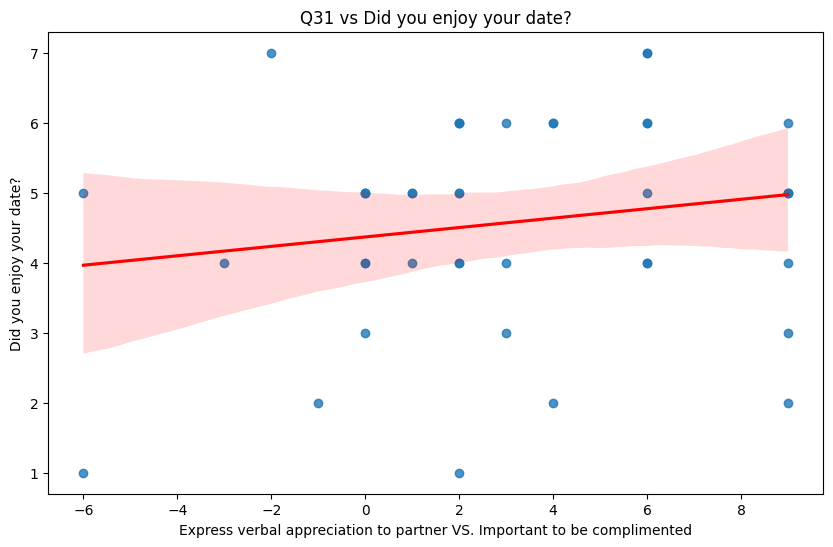

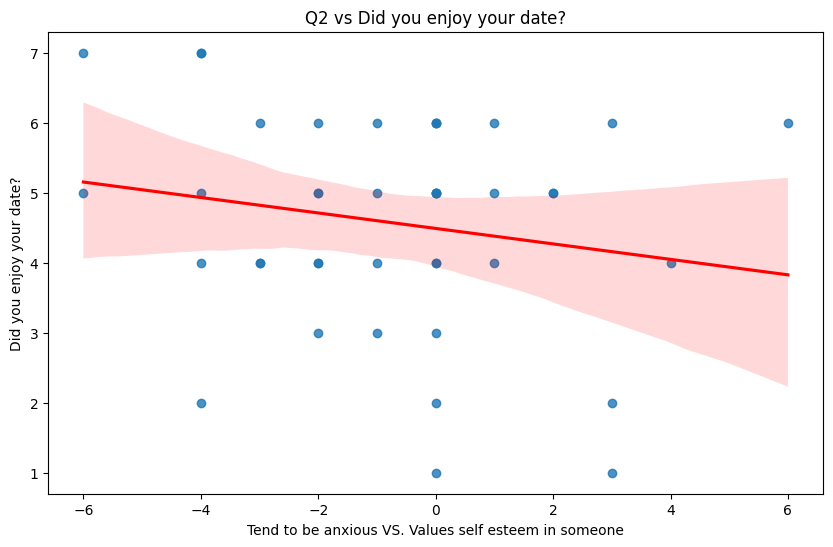

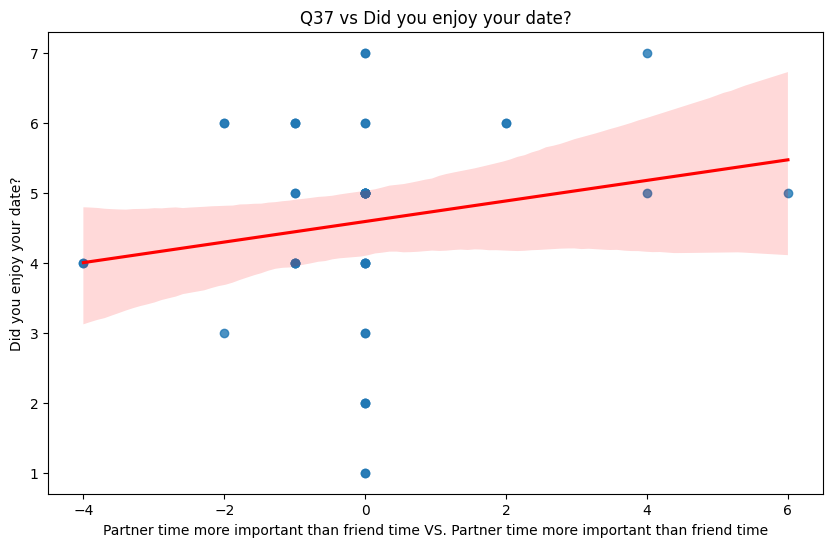

In [263]:
# Assign the partiular y variable as the 'Did you enjoy your date?' column.
y = df['Did you enjoy your date?'].astype(float)

# Split the data into training and testing sets, then fit it to the Linear Regression model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Print the coefficients in order of weight
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
coefficients = coefficients.sort_values(by='Coefficient', ascending=False)
# Print the 5 highest coefficients, the 5 lowest coefficients, and the 5 closest to 0
print("Top 5 coefficients:\n", coefficients.head(5))
print("\nBottom 5 coefficients:\n", coefficients.tail(5))
print("\nClosest to 0 coefficients:\n", coefficients.iloc[(coefficients['Coefficient'] - 0).abs().argsort()[:5]])

# Plot a graph of Q31 vs y with a regression line
plt.figure(figsize=(10, 6))
sns.regplot(x=X['Q31'], y=y, line_kws={"color": "red"}, ci=95)
plt.xlabel(qNames['Q31'])
plt.ylabel('Did you enjoy your date?')
plt.title('Q31 vs Did you enjoy your date?')
#plt.savefig('Q31_vs_y.png')    # Only needed once
plt.show()

# Plot a graph of Q2 vs y with a regression line
plt.figure(figsize=(10, 6))
sns.regplot(x=X['Q2'], y=y, line_kws={"color": "red"}, ci=95)
plt.xlabel(qNames['Q2'])
plt.ylabel('Did you enjoy your date?')
plt.title('Q2 vs Did you enjoy your date?')
#plt.savefig('Q2_vs_y.png')   # Only needed once
plt.show()

# Plot a graph of Q37 vs y with a regression line
plt.figure(figsize=(10, 6))
sns.regplot(x=X['Q37'], y=y, line_kws={"color": "red"}, ci=95)
plt.xlabel(qNames['Q37'])
plt.ylabel('Did you enjoy your date?')
plt.title('Q37 vs Did you enjoy your date?')
#plt.savefig('Q37_vs_y.png')    # Only needed once
plt.show()

Notably with Q37, multicolinearity prevented the variable from having much weight. Visibily in the graph, we can see that most reponses landed around the same line where x=0, so it makes sense that it doesn't contribute much to the final multivariable model. 

To fix this problem in comparisons, I wanted to analyze this problem and the following ones with forward stepwise selection. This helps eliminates less helpful variables strategically.

# 2) Multivaritate Linear Regression with Forward Stepwise Selection

In [ ]:
model = LinearRegression()

# Sequential Feature Selector
sfs = SFS(model,
          k_features=20,       # Chooses 'best amount' as opposed to a specified number like '10'
          forward=True,
          floating=False,
          scoring='neg_mean_squared_error',      # neg_mean_squared_error is used for compatibility with LOOCV
          cv=LeaveOneOut())        # LOOCV cv

<span style="color:Orange">'Did you enjoy your date?'</span>

In [332]:
# Selecting y outcome
y = df['Did you enjoy your date?'].astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

selection = sfs.fit(X_train, y_train)

featureSelection(selection)     # 13 seems optimal

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q51,Q52,Q53,Q54,Q55,Q56,Q57,Q58,Q59,Q60
7,0.0,-2.0,6.0,-0.0,-2.0,9.0,9.0,9.0,-1.0,6.0,...,-2.0,-6.0,1.0,1.0,-2.0,2.0,-4.0,-2.0,4.0,0.0
28,0.0,-1.0,6.0,-0.0,-2.0,3.0,4.0,9.0,-1.0,6.0,...,-2.0,-6.0,1.0,1.0,-2.0,2.0,-4.0,-2.0,4.0,0.0
13,-9.0,1.0,-2.0,-0.0,6.0,-2.0,2.0,3.0,-0.0,3.0,...,-6.0,-0.0,2.0,1.0,-3.0,0.0,6.0,2.0,9.0,-2.0
18,-1.0,3.0,4.0,-0.0,-1.0,-2.0,-0.0,6.0,0.0,4.0,...,-3.0,2.0,0.0,1.0,4.0,-0.0,2.0,2.0,9.0,6.0
10,-6.0,-2.0,-1.0,-0.0,-2.0,1.0,-1.0,-2.0,-1.0,6.0,...,0.0,-0.0,2.0,-2.0,-6.0,2.0,2.0,0.0,2.0,0.0


In [328]:
selection.k_feature_names_
selection.k_score_
pd.DataFrame.from_dict(selection.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(20,)","[-1.4419283559942577, -1.4419283559942577, -3....",-1.679939,"(Q21,)",0.728281,2.024944,0.357963
2,"(3, 20)","[-1.2701095301281153, -1.2701095301281153, -3....",-1.344758,"(Q4, Q21)",0.481446,1.338632,0.236639
3,"(3, 20, 27)","[-0.6212646515600382, -0.6212646515600382, -4....",-1.146252,"(Q4, Q21, Q28)",0.514486,1.430498,0.252879
4,"(3, 12, 20, 27)","[-0.0690978102763943, -0.16747464413233915, -3...",-0.964777,"(Q4, Q13, Q21, Q28)",0.558477,1.552813,0.274501
5,"(3, 12, 20, 27, 33)","[-0.2766376158534708, -0.04144494986569343, -2...",-0.82916,"(Q4, Q13, Q21, Q28, Q34)",0.434288,1.207514,0.21346
6,"(3, 12, 20, 27, 33, 39)","[-0.00649389339155391, -0.6051762243164546, -0...",-0.736095,"(Q4, Q13, Q21, Q28, Q34, Q40)",0.403793,1.122724,0.198471
7,"(3, 12, 20, 27, 33, 39, 42)","[-0.043267825541106815, -0.3136959614593432, -...",-0.648998,"(Q4, Q13, Q21, Q28, Q34, Q40, Q43)",0.365898,1.01736,0.179845
8,"(3, 12, 20, 27, 33, 34, 39, 42)","[-0.14647989231968195, -0.2324414629891881, -0...",-0.584387,"(Q4, Q13, Q21, Q28, Q34, Q35, Q40, Q43)",0.371393,1.032636,0.182546
9,"(3, 12, 15, 20, 27, 33, 34, 39, 42)","[-0.14585486827929134, -0.2206550959774358, -0...",-0.558371,"(Q4, Q13, Q16, Q21, Q28, Q34, Q35, Q40, Q43)",0.369432,1.027185,0.181582
10,"(3, 12, 15, 16, 20, 27, 33, 34, 39, 42)","[-0.21851786385269772, -0.15760083737270936, -...",-0.551901,"(Q4, Q13, Q16, Q17, Q21, Q28, Q34, Q35, Q40, Q43)",0.368265,1.02394,0.181009


<span style="color:Orange">'Did your personalities match?'</span>

In [268]:
# Selecting y outcome
y = df['Did your personalities match?'].astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

sfs = sfs.fit(X_train, y_train)

featureSelection(sfs)


Selected feature coefficients:
Q31     0.246   Express verbal appreciation to partner VS. Important to be complimented
Q12     0.185   Is center of attention VS. Likes quieter personality
Q40     0.182   Dark Humor [Humor]
Q55     0.151   Does LOUD equal funny? [Humor]
Q29     0.133   Great value in gift-giving VS. Not much value in receiving gifts
Q60     0.113   Meta Humor [Humor]
Q36     0.087   Don't like getting physical quick VS. Don't like getting physical quick
Q10     0.056   Easy to say sorry VS. Easy to say sorry
Q8      0.045   Having fun more important than winning VS. Having fun more important than winning
Q41     0.026   Self-Deprecating [Humor]
Q23     0.014   Bothered if personally not on time or early VS. Often late
Q6      0.002   Shut down when yelled at VS. Heated easily
Q37    -0.001   Partner time more important than friend time VS. Partner time more important than friend time
Q5     -0.002   Not embarrassed by others VS. Not embarrassed by others
Q59    -0.004 

<span style="color:Orange">'Was there a romantic tension?'</span>

In [269]:
# Selecting y outcome
y = df['Was there a romantic tension?'].astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

sfs = sfs.fit(X_train, y_train)

featureSelection(sfs)


Selected feature coefficients:
Q31     0.246   Express verbal appreciation to partner VS. Important to be complimented
Q29     0.133   Great value in gift-giving VS. Not much value in receiving gifts
Q37    -0.001   Partner time more important than friend time VS. Partner time more important than friend time
Q3     -0.007   Clearly articulate feelings VS. Clearly articulate feelings
Q30    -0.035   Texting over calls VS. Texting over calls
Q54    -0.050   How many booms do you give this survey [Question]
Q7     -0.059   Seek to resolve conflict VS. Sweep issues under the rug
Q20    -0.065   Enjoys a structured schedule VS. Enjoys a structured schedule
Q11    -0.070   Talk to strangers VS. Likes outgoing people
Q13    -0.099   Burdened by initiating convrersation VS. Tends to initiate
Q58    -0.106   Sexual Innuendo [Humor]


<span style="color:Orange">'Did you find them physically attractive?'</span>

In [270]:
# Selecting y outcome
y = df['Did you find them physically attractive?'].astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

sfs = sfs.fit(X_train, y_train)

featureSelection(sfs)


Selected feature coefficients:
Q31     0.246   Express verbal appreciation to partner VS. Important to be complimented
Q29     0.133   Great value in gift-giving VS. Not much value in receiving gifts
Q34     0.132   Importance on small physical gestures VS. Importance on small physical gestures
Q45     0.122   Observational Humor [Humor]
Q36     0.087   Don't like getting physical quick VS. Don't like getting physical quick
Q50     0.078   Witty Banter [Humor]
Q17     0.076   Seek out new experiences VS. Seek out new experiences
Q46     0.063   Absurdist/Nonsensical [Humor]
Q10     0.056   Easy to say sorry VS. Easy to say sorry
Q26     0.053   Reserved with emotions VS. Reserved with emotions
Q22     0.051   Enjoy serving others VS. Enjoy serving others
Q38     0.050   Slapstick [Humor]
Q33     0.038   Tend to be very affectionate VS. Tend to be very affectionate
Q41     0.026   Self-Deprecating [Humor]
Q57     0.021   Dad Jokes [Humor]
Q59    -0.004   Situational Comedy [Humor]
Q3  

SPECIAL ATEMPT

In [316]:
X = df[qVec]
y = df['Did you have a second date / is one lined up?'].astype(float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
forward_feature_selection = SFS(LinearRegression(n_jobs=-1),
                                k_features='best',
                                forward=True,
                                floating=False,
                                verbose=1,
                                scoring='r2',
                                cv=2)

model = forward_feature_selection.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
Features: 1/60[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
Features: 2/60[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
Features: 3/60[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
Features: 4/60[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
Features: 5/60[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
Features: 6/60[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
Features: 7/60[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
Features: 8/60[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
Features: 9/60[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
Features: 10/60[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
Features: 11/60[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
Features: 60/60

In [317]:
forward_feature_selection.k_feature_names_
forward_feature_selection.k_score_
pd.DataFrame.from_dict(model.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(20,)","[0.14213629128664806, 0.13975961538461545]",0.140948,"(Q21,)",0.005113,0.001188,0.001188
2,"(20, 35)","[0.22318272345504453, 0.20223322717679537]",0.212708,"(Q21, Q36)",0.045069,0.010475,0.010475
3,"(4, 20, 35)","[0.30191011552360414, 0.2508965570269627]",0.276403,"(Q5, Q21, Q36)",0.109747,0.025507,0.025507
4,"(4, 20, 35, 42)","[0.33660533817498006, 0.2655952769661343]",0.3011,"(Q5, Q21, Q36, Q43)",0.152766,0.035505,0.035505
5,"(4, 20, 29, 35, 42)","[0.3046969155429038, 0.3156099495754804]",0.310153,"(Q5, Q21, Q30, Q36, Q43)",0.023477,0.005457,0.005457
6,"(4, 20, 29, 35, 42, 45)","[0.2699732095349432, 0.38019042959574956]",0.325082,"(Q5, Q21, Q30, Q36, Q43, Q46)",0.237113,0.055109,0.055109
7,"(4, 20, 29, 35, 42, 45, 51)","[0.29782178341504584, 0.47626532303197955]",0.387044,"(Q5, Q21, Q30, Q36, Q43, Q46, Q52)",0.38389,0.089222,0.089222
8,"(4, 20, 29, 35, 38, 42, 45, 51)","[0.38895153850036723, 0.4971530116355669]",0.443052,"(Q5, Q21, Q30, Q36, Q39, Q43, Q46, Q52)",0.232777,0.054101,0.054101
9,"(4, 17, 20, 29, 35, 38, 42, 45, 51)","[0.45383839929335257, 0.5138383453746914]",0.483838,"(Q5, Q18, Q21, Q30, Q36, Q39, Q43, Q46, Q52)",0.129079,0.03,0.03
10,"(4, 17, 20, 29, 35, 38, 42, 45, 51, 57)","[0.4558033243203238, 0.5008750832006202]",0.478339,"(Q5, Q18, Q21, Q30, Q36, Q39, Q43, Q46, Q52, Q58)",0.096964,0.022536,0.022536


# 3) Linear Discriminant Analysis

In [221]:
# Choose a linear Discriminant analysis model
model = LDA()

# Sequential Feature Selector
sfs = SFS(model,
          k_features=(1, X.shape[1]),       # Chooses 'best amount' as opposed to a specified number like '10'
          forward=True,
          floating=False,
          scoring='accuracy',      # 'accuracy' is used for classification
          cv=LeaveOneOut())        # LOOCV cv

<span style="color:Orange">'Did you want a second date?'</span>

In [222]:
# Selecting y outcome (set Yes to 1 and No to 0)
y = df['Did you want a second date?']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

sfs = sfs.fit(X_train, y_train)

featureSelection(sfs)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:624: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = (S**2 / xp.sum(S**2))[
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:624: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = (S**2 / xp.sum(S**2))[
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:624: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = (S**2 / xp.sum(S**2))[



Selected feature coefficients:
      Coefficient
0               
Q31     0.246499
Q12     0.184776
Q40     0.181534
Q55     0.151444
Q17     0.076118
Q10     0.055539
Q26     0.052790
Q22     0.050931
Q56     0.041521
Q24     0.025361
Q37    -0.000881
Q5     -0.002086
Q3     -0.006955
Q27    -0.016969
Q9     -0.034025
Q4     -0.058119
Q7     -0.059049
Q18    -0.069382
Q52    -0.128245
Q32    -0.128489
Q19    -0.167052

Selected feature names: ['Clearly articulate feelings VS. Clearly articulate feelings', 'Unable to act / trapped in thoughts VS. Unable to act / trapped in thoughts', 'Not embarrassed by others VS. Not embarrassed by others', 'Seek to resolve conflict VS. Sweep issues under the rug', 'Persuaded more by something emotionally VS. Pursuaded more by something emotionally', 'Easy to say sorry VS. Easy to say sorry', 'Is center of attention VS. Likes quieter personality', 'Seek out new experiences VS. Seek out new experiences', 'Love to be in nature VS. Love to be in nature'

In [229]:
print(y_train.value_counts())

Do you expect to be friends with this person?
0    18
1    15
Name: count, dtype: int64


<span style="color:Orange">'Did you have a second date / is one lined up?'</span>

In [223]:
# Selecting y outcome (set Yes to 1 and No to 0)
y = df['Did you have a second date / is one lined up?']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

sfs = sfs.fit(X_train, y_train)

featureSelection(sfs)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:624: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = (S**2 / xp.sum(S**2))[
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:624: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = (S**2 / xp.sum(S**2))[
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:624: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = (S**2 / xp.sum(S**2))[
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:624: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = (S**2 / xp.sum(S**2))[
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/


Selected feature coefficients:
      Coefficient
0               
Q31     0.246499
Q12     0.184776
Q40     0.181534
Q55     0.151444
Q29     0.132595
Q36     0.087136
Q50     0.078090
Q46     0.063394
Q10     0.055539
Q22     0.050931
Q8      0.045478
Q56     0.041521
Q33     0.037794
Q57     0.020987
Q6      0.001580
Q37    -0.000881
Q3     -0.006955
Q16    -0.032850
Q9     -0.034025
Q30    -0.034602
Q54    -0.050044
Q4     -0.058119
Q7     -0.059049
Q42    -0.067261
Q18    -0.069382
Q11    -0.069840
Q15    -0.069920
Q49    -0.083933
Q25    -0.084265
Q44    -0.085641
Q13    -0.099251
Q35    -0.111568
Q52    -0.128245
Q32    -0.128489
Q21    -0.140538
Q1     -0.189905
Q2     -0.327522

Selected feature names: ['Cries often VS. Uncofmortable consoling the unwell', 'Tend to be anxious VS. Values self esteem in someone', 'Clearly articulate feelings VS. Clearly articulate feelings', 'Unable to act / trapped in thoughts VS. Unable to act / trapped in thoughts', 'Shut down when yelled at 

<span style="color:Orange">'Do you expect to be friends with this person?'</span>

In [224]:
# Selecting y outcome (set Yes to 1 and No to 0)
y = df['Do you expect to be friends with this person?']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

sfs = sfs.fit(X_train, y_train)

# Show a line for the linear discriminant analysis
lda = LDA()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)

featureSelection(sfs)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:624: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = (S**2 / xp.sum(S**2))[
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:624: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = (S**2 / xp.sum(S**2))[
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:624: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = (S**2 / xp.sum(S**2))[
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:624: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = (S**2 / xp.sum(S**2))[
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/


Selected feature coefficients:
      Coefficient
0               
Q31     0.246499
Q12     0.184776
Q40     0.181534
Q45     0.122423
Q60     0.112812
Q50     0.078090
Q17     0.076118
Q10     0.055539
Q48     0.051896
Q22     0.050931
Q38     0.049796
Q39     0.038347
Q33     0.037794
Q23     0.013895
Q6      0.001580
Q5     -0.002086
Q3     -0.006955
Q16    -0.032850
Q9     -0.034025
Q4     -0.058119
Q20    -0.064692
Q18    -0.069382
Q11    -0.069840
Q28    -0.083572
Q49    -0.083933
Q44    -0.085641
Q14    -0.095324
Q51    -0.098825
Q13    -0.099251
Q19    -0.167052
Q2     -0.327522

Selected feature names: ['Tend to be anxious VS. Values self esteem in someone', 'Clearly articulate feelings VS. Clearly articulate feelings', 'Unable to act / trapped in thoughts VS. Unable to act / trapped in thoughts', 'Not embarrassed by others VS. Not embarrassed by others', 'Shut down when yelled at VS. Heated easily', 'Persuaded more by something emotionally VS. Pursuaded more by something emot

# 4) Logistic Regression

In [286]:
# Choose a logistic regression model
model = LogisticRegression(max_iter=1000)

# Sequential Feature Selector
sfs = SFS(model,
          k_features='best',       # Chooses 'best amount' as opposed to a specified number like '10'
          forward=True,
          floating=False,
          scoring='accuracy',      # accuracy score used to determine which variables are most important
          cv=LeaveOneOut()) 

<span style="color:Orange">'Did you want a second date?'</span>

In [287]:
# Selecting y outcome (set Yes to 1 and No to 0)
y = df['Did you want a second date?']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

sfs = sfs.fit(X_train, y_train)

featureSelection(sfs)


Selected feature coefficients:
Q40     0.182   Dark Humor [Humor]
Q26     0.053   Reserved with emotions VS. Reserved with emotions
Q39     0.038   Sarcasm [Humor]
Q24     0.025   Worry about the future VS. Worry about the future
Q23     0.014   Bothered if personally not on time or early VS. Often late
Q18    -0.069   Love to be in nature VS. Love to be in nature
Q44    -0.086   Deadpan [Humor]


In [293]:
# Get the selected features
selected_features = list(sfs.k_feature_names_)

# Train a new model on training data using only selected features
model.fit(X_train[selected_features], y_train)

# Evaluate on the test data using the same features
y_pred = model.predict(X_test[selected_features])
print(y_pred)
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)


[0 0 0 0 0 1 1 0 1]
Accuracy: 0.4444444444444444


<span style="color:Orange">'Did you have a second date / is one lined up?'</span>

In [294]:
# Selecting y outcome (set Yes to 1 and No to 0)
y = df['Did you have a second date / is one lined up?']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

sfs = sfs.fit(X_train, y_train)

featureSelection(sfs)


Selected feature coefficients:
Q12     0.185   Is center of attention VS. Likes quieter personality
Q34     0.132   Importance on small physical gestures VS. Importance on small physical gestures
Q36     0.087   Don't like getting physical quick VS. Don't like getting physical quick
Q46     0.063   Absurdist/Nonsensical [Humor]
Q53     0.063   Brain Rot [Humor]
Q10     0.056   Easy to say sorry VS. Easy to say sorry
Q8      0.045   Having fun more important than winning VS. Having fun more important than winning
Q41     0.026   Self-Deprecating [Humor]
Q6      0.002   Shut down when yelled at VS. Heated easily
Q5     -0.002   Not embarrassed by others VS. Not embarrassed by others
Q3     -0.007   Clearly articulate feelings VS. Clearly articulate feelings
Q9     -0.034   Persuaded more by something emotionally VS. Pursuaded more by something emotionally
Q4     -0.058   Unable to act / trapped in thoughts VS. Unable to act / trapped in thoughts
Q11    -0.070   Talk to strangers VS. Lik

<span style="color:Orange">'Do you expect to be friends with this person?'</span>

In [228]:
# Selecting y outcome (set Yes to 1 and No to 0)
y = df['Do you expect to be friends with this person?']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

sfs = sfs.fit(X_train, y_train)

featureSelection(sfs)


Selected feature coefficients:
      Coefficient
0               
Q17     0.076118
Q3     -0.006955
Q54    -0.050044
Q7     -0.059049
Q18    -0.069382
Q28    -0.083572
Q19    -0.167052

Selected feature names: ['Clearly articulate feelings VS. Clearly articulate feelings', 'Seek to resolve conflict VS. Sweep issues under the rug', 'Seek out new experiences VS. Seek out new experiences', 'Love to be in nature VS. Love to be in nature', 'Bedroom is clean and tidy VS. Messy space is aggravating', 'Okay lying to spare feelings VS. Okay lying to spare feelings', 'How many booms do you give this survey [Question]']
